Imports

In [25]:
__author__ = "Artur Fejklowicz"

# Sources:
# - https://medium.com/@ashins1997/text-classification-dfe370bf7044
# - https://www.kaggle.com/code/shahkan/text-classification-using-logistic-regression
# - https://www.kaggle.com/code/satishgunjal/multiclass-logistic-regression-using-sklearn
# - https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# - https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from google.cloud import bigquery
import matplotlib.pyplot as plt
import nltk.stem.snowball
from sklearn.metrics import ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
#import seaborn as sns
import urllib.request



Retrive data from BigQuery

In [26]:
client = bigquery.Client(project="af-finanzen")
query = ("""SELECT
  description
  -- , Konto
  , CASE 
      WHEN Konto in ("PK Auto", "PK Maja", "PK Rest", "SK Haushalt", "Top-Up") THEN "Others"
      ELSE Konto
    END as Konto
FROM banks.revolut_mapping_internal
""")
df = client.query(query).to_dataframe()  # API request


## Data analysis

Basic

Number of classes: 5
Class names: ['Others' 'PK Artur' 'PK Leben' 'PK Reisen' 'SK Ferien']
Konto
Others        66
PK Artur      75
PK Leben     105
PK Reisen     70
SK Ferien     86
Name: Konto, dtype: int64


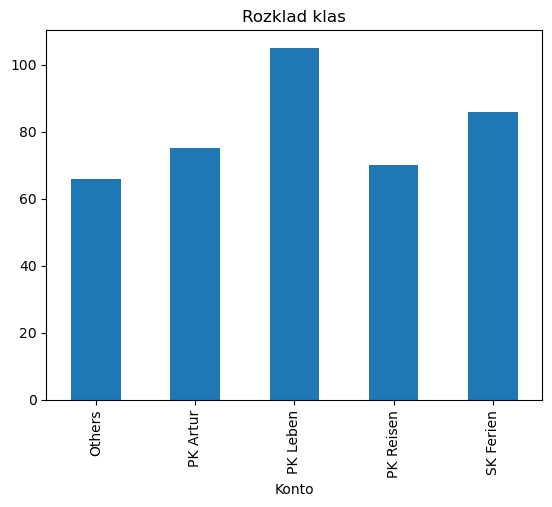

,description,Konto
0,Top-Up by *4356,Others
1,Refund from Amz*smithy By Dagmar N,Others
2,Splasz Studio Detailin,Others
3,Kraken Detailing,Others
4,Cash at Bienczycki Pl Targowy,Others
5,Wegrzyn & Wegrzyn S.j.,Others
6,Ley Autowaschpark W5,Others
7,Gama-M,Others
8,Fikołki,Others
9,Mini Melts Spolka Z O.o,Others


In [55]:
n_classes = df.Konto.nunique()
print(f"Number of classes: {n_classes}")

target_names = df.Konto.unique()
print(f"Class names: {target_names}")

print(df.groupby("Konto").Konto.count())
df.groupby("Konto").Konto.count().plot(kind="bar", ylim=0, )
plt.title("Rozklad klas")
plt.show()

# df["Konto"].astype("category").cat.codes.plot(kind="hist", color="green", width=0.8)
# plt.show()
# df.info()

pd.concat( [df.head(10), df.tail(10)] )

Histogram of words

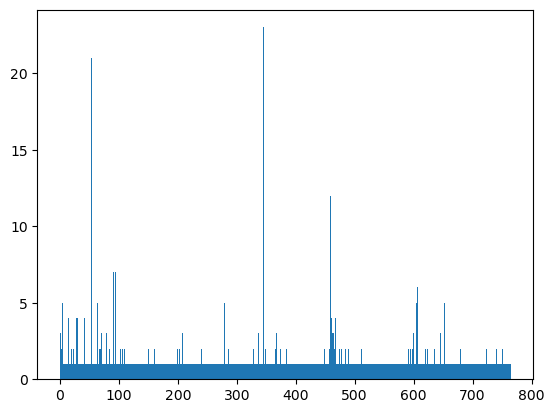

996 766


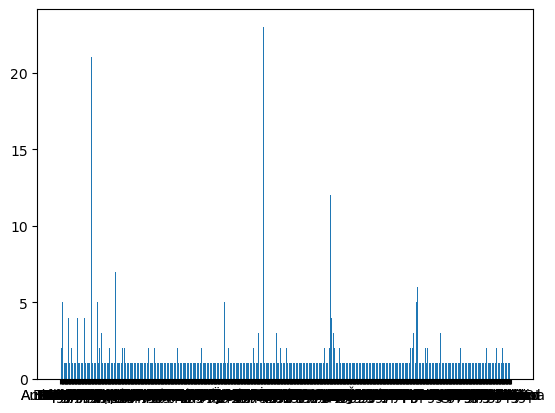

description    23
Konto          23
dtype: int64

In [28]:
hist_words_mapping = {}
hist_words = []

for document in df.description.to_list():
    words = document.split(" ")
    for word in words:
        if word not in hist_words_mapping.keys():
            hist_words_mapping[word] = len(hist_words_mapping)

    hist_words = hist_words + list(map(lambda w: hist_words_mapping[w], words))

plt.hist(hist_words, width=1, bins=766)
plt.show()

print(len(hist_words), len(hist_words_mapping))


words = [line.split() for line in df.description]
from collections import Counter
from itertools import chain
counter = Counter(chain.from_iterable(words))
#print(counter)

author_names = counter.keys()
author_counts = counter.values()

indexes = np.arange(len(author_names))
width = 0.7
plt.bar(indexes, author_counts, width)
plt.xticks(indexes + width * 0.5, author_names)
plt.show()

df[df.description.str.contains("Manual")].count()


Seaborn

In [29]:
# sns.set_theme()
# #df.groupby("Konto").Konto.count()
# sns.countplot(data=df, x="Konto")

Stopwords

In [30]:
stops_eng = set(stopwords.words('english'))
stops_ger = set(stopwords.words('german'))
stops_ita = set(stopwords.words('italian'))
stops_spa = set(stopwords.words('spanish'))
stops_fra = set(stopwords.words('french'))
# stops_pol = set(load_lines_from_file("../../python/logistic_regression_classification/polish.txt"))
link = "https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt"
lines=[]
responce = urllib.request.urlopen(link)
stops_pol = responce.read().decode().split(f"\n")

stops = list(stops_eng.union(stops_ger).union(stops_ita).union(stops_spa).union(stops_fra).union(stops_pol))
# if stops_pol:
#     stops = stops.union(stops_pol)
# stops = list(stops)

# stops=[]



Vectorization

In [31]:
vectorizer = TfidfVectorizer(
    #min_df=0.0001,
    stop_words=stops,
    #max_features=1000,
    sublinear_tf=True, 
    #norm='l2', 
    ngram_range=(1, 1))
final_features = vectorizer.fit_transform(df['description']).toarray()
print(f"final_features.shape:\n{final_features.shape}")
#np.set_printoptions(threshold=np.inf)
#print(f"final_featurese:\n{final_features}")
# print(f"vectorizer.get_feature_names_out() {vectorizer.get_feature_names_out()}")


final_features.shape:
(402, 683)


Train Test Split

In [32]:
X = df['description']
Y = df['Konto']
# print(f"Y {Y}")

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


Build and train model

In [33]:


pipeline = Pipeline([('vect', vectorizer),
                     #('chi',  SelectKBest(chi2, k="all")),
                     ('clf',  LogisticRegression(multi_class='ovr', solver='liblinear', random_state=0))])


model = pipeline.fit(X_train, y_train)


Test and print report

In [34]:
ytest = np.array(y_test)

#c_names = pipeline.feature_names_in_
#print(f"c_names: {c_names}")
#print(f"get_feature_names_out: {model.feature_names_in_}")

classification_report = classification_report(ytest, model.predict(X_test))

print(classification_report)

              precision    recall  f1-score   support

      Others       0.50      0.31      0.38        13
    PK Artur       0.75      0.23      0.35        13
    PK Leben       0.37      0.88      0.52        25
   PK Reisen       1.00      0.53      0.70        15
   SK Ferien       1.00      0.13      0.24        15

    accuracy                           0.48        81
   macro avg       0.72      0.42      0.44        81
weighted avg       0.69      0.48      0.45        81



Confusion Matrix Training Data

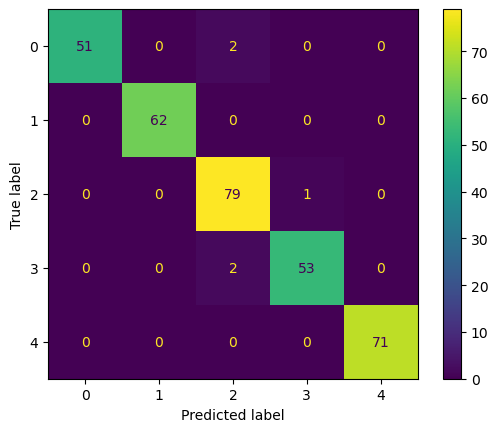

In [35]:
confusion_matrix_training = confusion_matrix(np.array(y_train), model.predict(X_train))
# print(confusion_matrix_training)
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training, display_labels=n_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_training)
disp.plot()
plt.show()

Confusion Matrix Testing Data

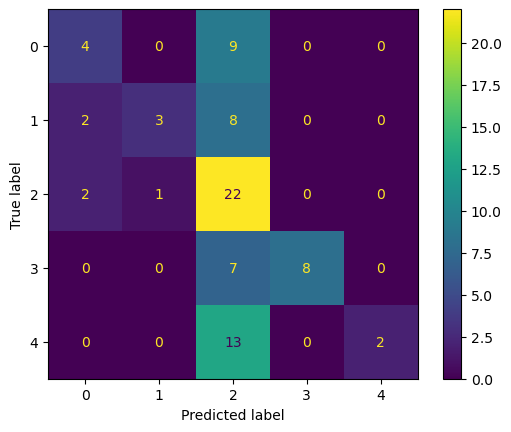

In [36]:
confusion_matrix_testing = confusion_matrix(ytest, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_testing)
disp.plot()
plt.show()

## ROC
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py


In [38]:
y_score = model.predict_proba(X_test)
print(f"Scores: {y_score}")
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

Scores: [[0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.27856718 0.1814374  0.25452701 0.11851457 0.16695385]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.15235051 0.2598968  0.2333232  0.14221004 0.21221944]
 [0.14587908 0.17827257 0.33769657 0.13635012 0.20180166]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.38622817 0.1758024  0.16945152 0.11187519 0.15664273]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.37199374 0.22376933 0.22700215 0.07753482 0.09969995]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16262914 0.20153248 0.25430188 0.15133124 0.23020526]
 [0.16

(81, 5)

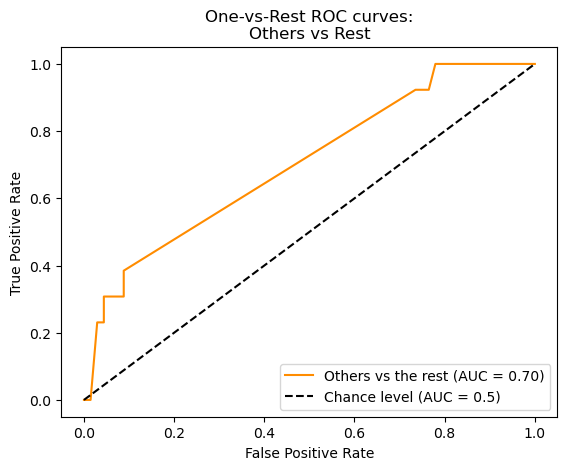

In [41]:
label_binarizer.transform(["Others"])
class_of_interest = "Others"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id


from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nOthers vs Rest",
)

In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging

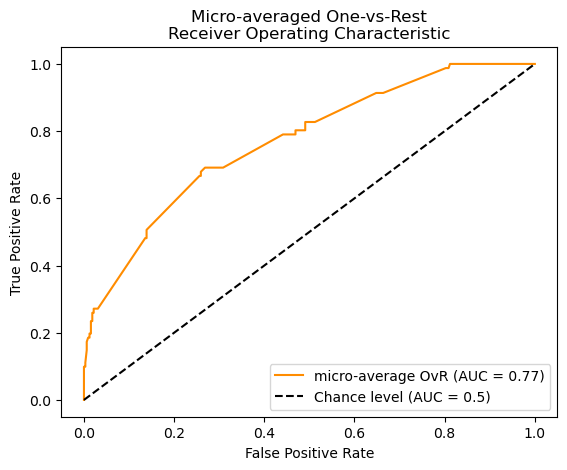

In [42]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

Micro-averageg

In [46]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


Macro-averaged

In [45]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.72


## Plot all classes together
Obtaining the macro-average requires computing the metric independently for each class and then taking the average over them, hence treating all classes equally a priori. We first aggregate the true/false positive rates per class:

Micro-averaged One-vs-Rest ROC AUC score:
0.77
Macro-averaged One-vs-Rest ROC AUC score:
0.72
Macro-averaged One-vs-Rest ROC AUC score:
0.72


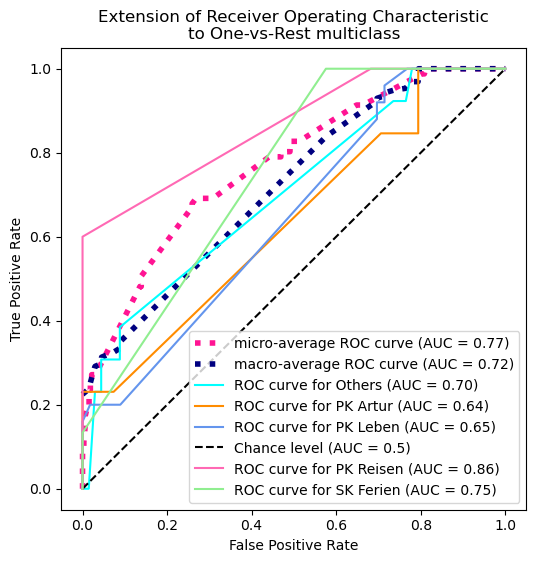

In [59]:
from sklearn.metrics import auc, roc_curve


# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")




for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")





for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")



from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "hotpink", "lightgreen"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)